In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

2024-08-06 19:17:30.613197: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 19:17:30.613236: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 19:17:30.613262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 19:17:30.621435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 19:17:31.790879: W tensorflow/compiler/

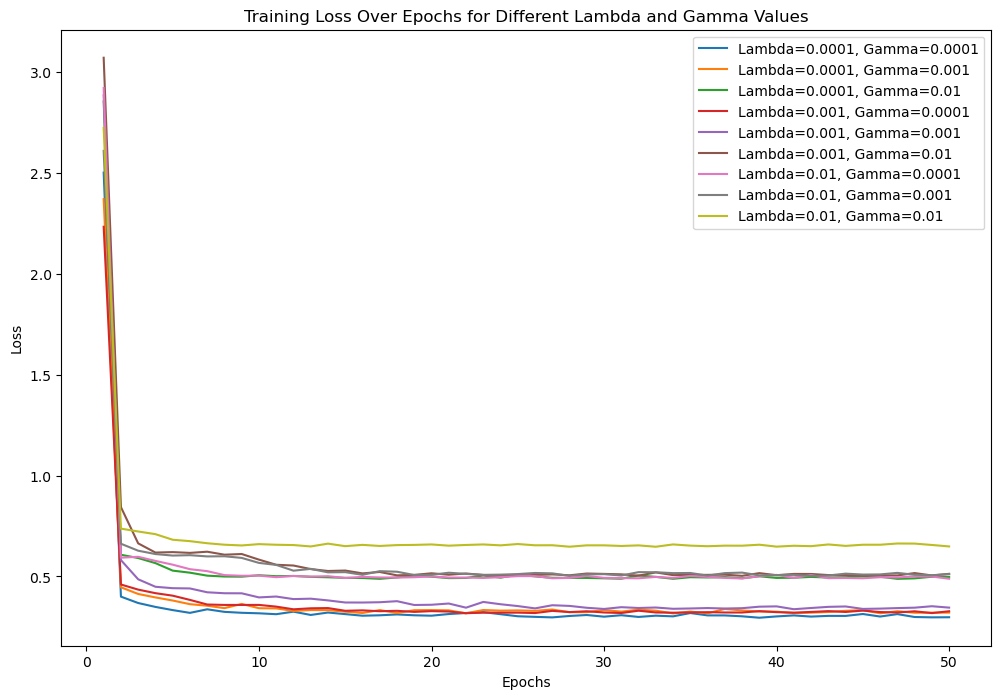

In [2]:
np.random.seed(0)
num_samples = 5000

x1 = np.random.uniform(0, 10, num_samples)
x2 = np.random.uniform(0, 5, num_samples)
x3 = np.random.uniform(0, 2, num_samples)
a = 2.5
b = 1.8
c = 0.7
noise = np.random.normal(0, 1, num_samples)
y = a * x1 + b * x2 + c * x3 + noise
data = np.column_stack((x1, x2, x3, y))
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=42)

def quantile_loss(y_true, y_pred, alpha):
    k = y_pred[:, 0]
    m = y_pred[:, 1]
    quantile_loss = alpha * (tf.keras.backend.maximum(0.0, y_true - m) + tf.keras.backend.maximum(0.0, k - y_true))
    return quantile_loss

def custom_loss(y_true, y_pred, delta, alpha, lambda_value, gamma_value):
    huber_loss = tf.keras.losses.Huber(delta)
    k = y_pred[:, 0]
    m = y_pred[:, 1]
    h_loss = huber_loss(y_true, (k + m) / 2)
    q_loss = quantile_loss(y_true, y_pred, alpha)
    lower_bound_loss = tf.keras.backend.maximum(0.0, y_true - k)
    upper_bound_loss = tf.keras.backend.maximum(0.0, m - y_true)
    loss = lambda_value * tf.reduce_mean(lower_bound_loss) + gamma_value * tf.reduce_mean(upper_bound_loss) + tf.reduce_mean(q_loss) + h_loss
    return loss

lambda_values = [0.0001, 0.001, 0.01]
gamma_values = [0.0001, 0.001, 0.01]

plt.figure(figsize=(12, 8))

for lambda_val in lambda_values:
    for gamma_val in gamma_values:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(3,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(2)
        ])
        model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 0.5, 0.1, lambda_val, gamma_val))
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        loss_values = history.history['loss']
        label_str = f'Lambda={lambda_val}, Gamma={gamma_val}'
        plt.plot(np.arange(1, 51), loss_values, label=label_str)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Different Lambda and Gamma Values')
plt.legend()
plt.show()


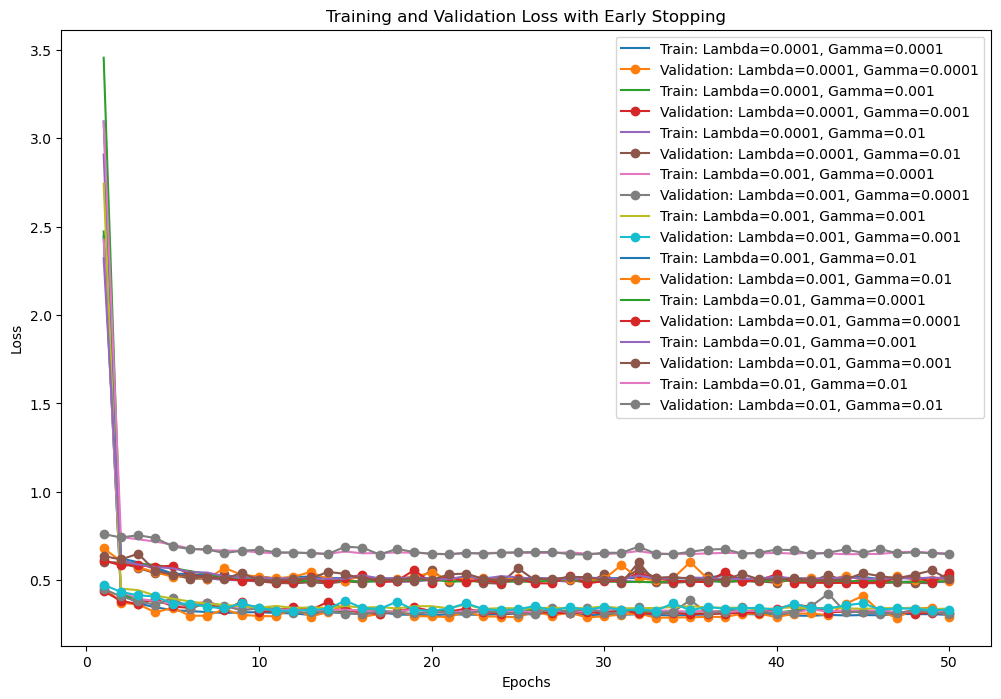

In [3]:
plt.figure(figsize=(12, 8))
for lambda_val in lambda_values:
    for gamma_val in gamma_values:
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(3,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(2)
        ])
        model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 0.5, 0.1, lambda_val, gamma_val))
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)
        loss_values = history.history['loss']
        val_loss_values = history.history['val_loss']
        label_str = f'Train: Lambda={lambda_val}, Gamma={gamma_val}'
        plt.plot(np.arange(1, len(loss_values) + 1), loss_values, label=label_str)
        label_str = f'Validation: Lambda={lambda_val}, Gamma={gamma_val}'
        plt.plot(np.arange(1, len(val_loss_values) + 1), val_loss_values, label=label_str, marker='o')
        
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Early Stopping')
plt.legend()
plt.show()

In [4]:
np.random.seed(0)
num_samples = 1000
x1 = np.random.uniform(0, 10, num_samples)
x2 = np.random.uniform(0, 5, num_samples)
x3 = np.random.uniform(0, 2, num_samples)

a = 2.5
b = 1.8
c = 0.7

noise = np.random.normal(0, 1, num_samples)
y = a * x1 + b * x2 + c * x3 + noise

data = np.column_stack((x1, x2, x3, y))
X_train, X_test, y_train, y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.2, random_state=42)

7/7 [==============================] - 0s 1ms/step


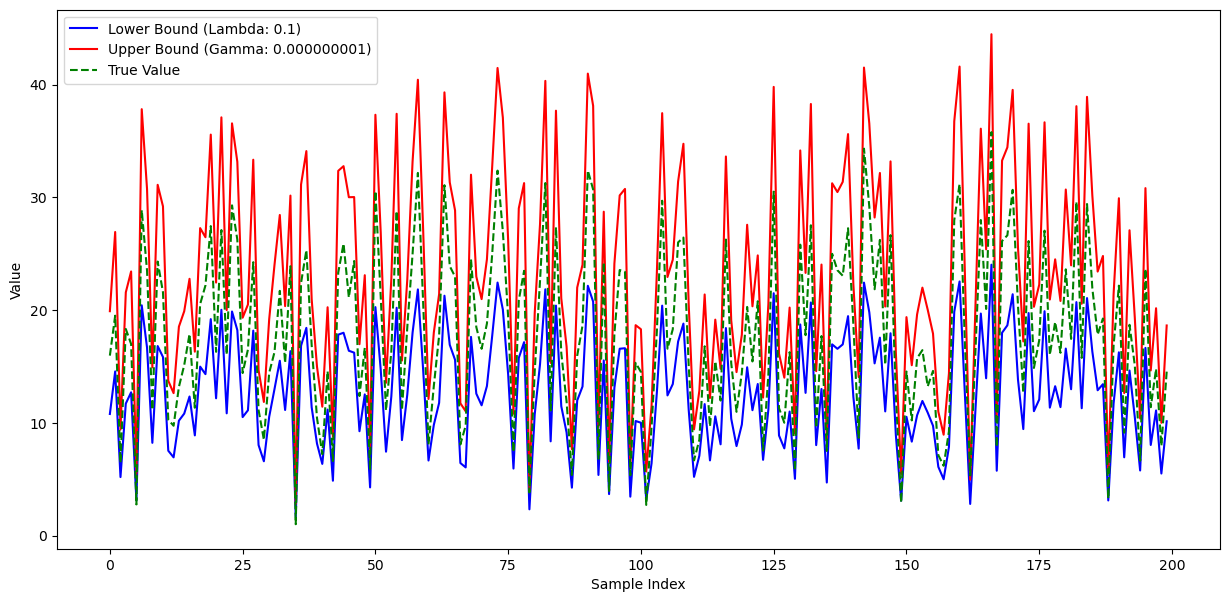

In [5]:
def quantile_loss(y_true, y_pred, alpha):
    k = y_pred[:, 0]
    m = y_pred[:, 1]
    quantile_loss = alpha * (tf.keras.backend.maximum(0.0, y_true - m) + tf.keras.backend.maximum(0.0, k - y_true))
    return quantile_loss

def custom_loss(y_true, y_pred, delta, alpha):
    huber_loss = tf.keras.losses.Huber(delta)
    k = y_pred[:, 0]
    m = y_pred[:, 1]
    lambda_value = 0.1
    gamma_value = 0.000000001
    h_loss = huber_loss(y_true, (k + m) / 2)
    q_loss = quantile_loss(y_true, y_pred, alpha)
    lower_bound_loss = tf.keras.backend.maximum(0.0, y_true - k)
    upper_bound_loss = tf.keras.backend.maximum(0.0, m - y_true)

    loss = lambda_value * tf.reduce_mean(lower_bound_loss) + gamma_value * tf.reduce_mean(upper_bound_loss) + tf.reduce_mean(q_loss) + h_loss
    return loss

def create_model_with_regularization(l2_weight):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight), input_shape=(3,)))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(2))
    return model

model = create_model_with_regularization(l2_weight=0.0001)

model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 0.5, 0.1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

interval_preds = model.predict(X_test)
lower_preds = interval_preds[:, 0]
upper_preds = interval_preds[:, 1]

x_values = np.arange(len(y_test))

plt.figure(figsize=(15, 7))
plt.plot(x_values, lower_preds, label=f'Lower Bound (Lambda: 0.1)', color='blue')
plt.plot(x_values, upper_preds, label=f'Upper Bound (Gamma: 0.000000001)', color='red')
plt.plot(x_values, y_test, label='True Value', linestyle='--', color='green')

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.savefig('strict lower bound.png')
plt.show()

In [6]:
width = upper_preds - lower_preds
print("Interval width is:",width.mean())
covered_samples = ((lower_preds <= y_test) & (upper_preds >= y_test)).sum()
coverage = covered_samples / len(X_test)
print("Coverage rate is:", coverage)

Interval width is: 10.62885
Coverage rate is: 0.975


7/7 [==============================] - 0s 1ms/step


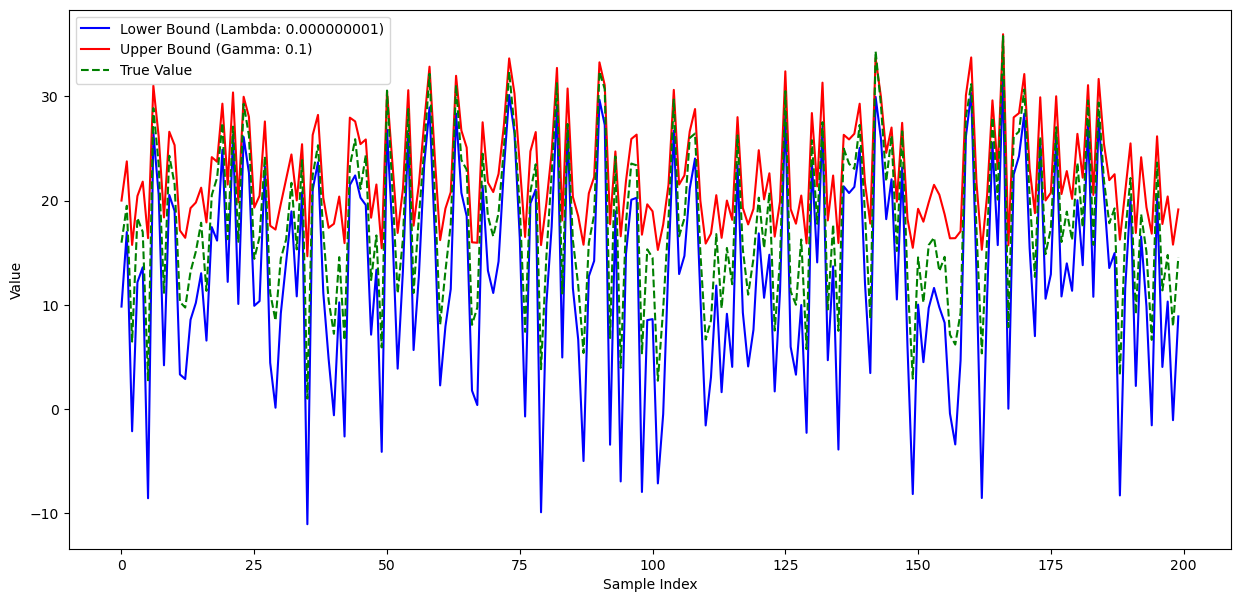

In [7]:
def quantile_loss(y_true, y_pred, alpha):
    k = y_pred[:, 0]
    m = y_pred[:, 1]
    quantile_loss = alpha * (tf.keras.backend.maximum(0.0, y_true - m) + tf.keras.backend.maximum(0.0, k - y_true))
    return quantile_loss

def custom_loss(y_true, y_pred, delta, alpha):
    huber_loss = tf.keras.losses.Huber(delta)
    k = y_pred[:, 0]
    m = y_pred[:, 1]
    lambda_value = 0.000000001
    gamma_value = 0.1
    h_loss = huber_loss(y_true, (k + m) / 2)
    q_loss = quantile_loss(y_true, y_pred, alpha)
    lower_bound_loss = tf.keras.backend.maximum(0.0, y_true - k)
    upper_bound_loss = tf.keras.backend.maximum(0.0, m - y_true)

    loss = lambda_value * tf.reduce_mean(lower_bound_loss) + gamma_value * tf.reduce_mean(upper_bound_loss) + tf.reduce_mean(q_loss) + h_loss
    return loss

def create_model_with_regularization(l2_weight):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight), input_shape=(3,)))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_weight)))
    model.add(tf.keras.layers.Dense(2))
    return model

model = create_model_with_regularization(l2_weight=0.0001)

model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, 0.5, 0.1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stopping])

interval_preds = model.predict(X_test)
lower_preds = interval_preds[:, 0]
upper_preds = interval_preds[:, 1]

x_values = np.arange(len(y_test))

plt.figure(figsize=(15, 7))
plt.plot(x_values, lower_preds, label=f'Lower Bound (Lambda: 0.000000001)', color='blue')
plt.plot(x_values, upper_preds, label=f'Upper Bound (Gamma: 0.1)', color='red')
plt.plot(x_values, y_test, label='True Value', linestyle='--', color='green')

plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.savefig('strict upper bound.png')
plt.show()

In [8]:
width = upper_preds - lower_preds
print("Interval width is:",width.mean())
covered_samples = ((lower_preds <= y_test) & (upper_preds >= y_test)).sum()
coverage = covered_samples / len(X_test)
print("Coverage rate is:", coverage)

Interval width is: 9.633741
Coverage rate is: 0.99
